In [3]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
import os

# **Ensure the "models/XGB/" directory exists**
model_save_path = "models/XGB"
os.makedirs(model_save_path, exist_ok=True)  # Creates "models/XGB" if it doesn't exist


# Manually set the project root directory (adjust if needed)
project_root = os.path.abspath("..")  # Moves up one level to project root

# Add the project directory to sys.path
sys.path.append(project_root)

# Now import the GRU model
from Models.GRU import GRUModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from Models.GRU import GRUModel   # Import the GRU model
from Training.PyTorchModular import train_model
import torch.nn as nn
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor


[I 2025-02-18 12:15:54,559] A new study created in memory with name: no-name-1ab23dae-335a-4537-b3c1-c39a43d00001
[I 2025-02-18 12:15:54,830] Trial 0 finished with value: 4.526811512673571 and parameters: {'max_depth': 6, 'learning_rate': 0.08619630424072657, 'n_estimators': 283, 'subsample': 0.8472107413442455, 'colsample_bytree': 0.8921193742415192}. Best is trial 0 with value: 4.526811512673571.
[I 2025-02-18 12:15:55,091] Trial 1 finished with value: 4.5241072016137 and parameters: {'max_depth': 4, 'learning_rate': 0.2815089877397462, 'n_estimators': 377, 'subsample': 0.7409342868016777, 'colsample_bytree': 0.8493443165170564}. Best is trial 1 with value: 4.5241072016137.
[I 2025-02-18 12:15:55,403] Trial 2 finished with value: 4.522703088427962 and parameters: {'max_depth': 7, 'learning_rate': 0.08534473714411307, 'n_estimators': 260, 'subsample': 0.633526872735975, 'colsample_bytree': 0.8631104912595121}. Best is trial 2 with value: 4.522703088427962.
[I 2025-02-18 12:15:55,536] 

Best Hyperparameters: {'max_depth': 3, 'learning_rate': 0.0394634738807157, 'n_estimators': 439, 'subsample': 0.7155730589343159, 'colsample_bytree': 0.6585858384845887}
Early stopping at round 383, best RMSE: 4.490889 at iteration 363
 Best Model Saved in `models/XGB` as: models/XGB\XGBoost_Inflation_BEST_STOPPED_AT_363.pth with RMSE: 4.490889


c:\Users\sandr\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


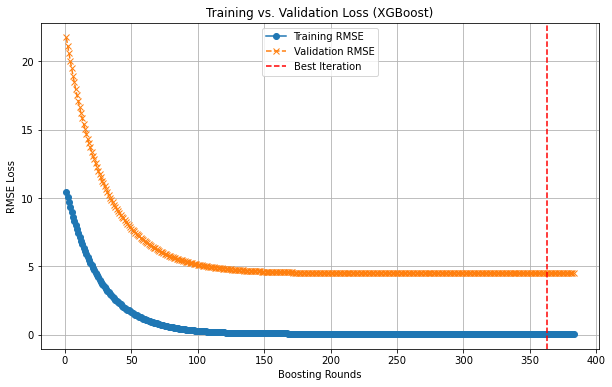

Final Validation RMSE: 4.490889


In [5]:
import sys
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import optuna
import json

# **Create Directory for Model Saving**
save_dir = "models/XGB"
os.makedirs(save_dir, exist_ok=True)  # Create folder if it doesn't exist

# **Load the Data**
train_file = "..\\Data\\Train\\trains1990s.csv"
df = pd.read_csv(train_file, parse_dates=['observation_date'])
df.rename(columns={'observation_date': 'Date', 'fred_PCEPI': 'Inflation'}, inplace=True)
df.set_index('Date', inplace=True)

# **Function to Prepare Dataset**
def prepare_inflation_dataset(df, days_list):
    df = df[['Inflation']].copy()
    features = ['Inflation']
    for day in days_list:
        df[f'Inflation_{day}d'] = df['Inflation'].shift(day)
        features.append(f'Inflation_{day}d')
    df.dropna(inplace=True)
    df['Target'] = df['Inflation'].shift(-1)
    df.dropna(inplace=True)
    return df, features

# **Prepare Dataset**
days_list = [1, 2, 3, 5, 10]
df, features = prepare_inflation_dataset(df, days_list)

# **Train-Validation Split**
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)
train_df, val_df = df.iloc[:split_idx], df.iloc[split_idx:]
X_train, y_train = train_df[features], train_df['Target']
X_val, y_val = val_df[features], val_df['Target']

# **OPTUNA HYPERPARAMETER TUNING**
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    val_pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, val_pred))

# **Run Optuna Study**
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# **Train Best Model Using Found Hyperparameters**
best_xgb_model = XGBRegressor(**best_params)
evals_result = {"train": [], "val": []}
best_rmse = float("inf")
best_iteration = 0
patience = 20
no_improve_count = 0

# **Train Model with Early Stopping & Logging**
for i in range(1, best_params["n_estimators"] + 1):
    best_xgb_model.set_params(n_estimators=i)
    best_xgb_model.fit(X_train, y_train, verbose=False)

    train_pred = best_xgb_model.predict(X_train)
    val_pred = best_xgb_model.predict(X_val)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    evals_result["train"].append(train_rmse)
    evals_result["val"].append(val_rmse)

    # **Early Stopping Logic**
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_iteration = i
        no_improve_count = 0
    else:
        no_improve_count += 1

    if no_improve_count >= patience:
        print(f"Early stopping at round {i}, best RMSE: {best_rmse:.6f} at iteration {best_iteration}")
        break

# **Set Best Model**
best_xgb_model.set_params(n_estimators=best_iteration)
best_xgb_model.fit(X_train, y_train, verbose=False)

# **Save Best Model in `models/XGB/`**
best_model_path = os.path.join(save_dir, f"XGBoost_Inflation_BEST_STOPPED_AT_{best_iteration}.pth")
latest_model_path = os.path.join(save_dir, "XGBoost_Inflation_latest.pth")

best_xgb_model.save_model(best_model_path)
best_xgb_model.save_model(latest_model_path)

# Save training logs as JSON
training_log_path = os.path.join(save_dir, "training_log.json")
training_log = {
    "best_iteration": best_iteration,
    "best_rmse": best_rmse,
    "train_loss": evals_result["train"],
    "val_loss": evals_result["val"]
}

with open(training_log_path, "w") as f:
    json.dump(training_log, f, indent=4)

print(f" Best Model Saved in `{save_dir}` as: {best_model_path} with RMSE: {best_rmse:.6f}")

# **Plot Training vs. Validation Loss**
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(evals_result["train"]) + 1), evals_result["train"], label="Training RMSE", marker="o", linestyle="-")
plt.plot(range(1, len(evals_result["val"]) + 1), evals_result["val"], label="Validation RMSE", marker="x", linestyle="--")
plt.axvline(x=best_iteration, color="r", linestyle="--", label="Best Iteration")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE Loss")
plt.title("Training vs. Validation Loss (XGBoost)")
plt.legend()
plt.grid()
plt.show()

# **Predict on Validation Set**
y_pred = best_xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Final Validation RMSE: {rmse:.6f}")


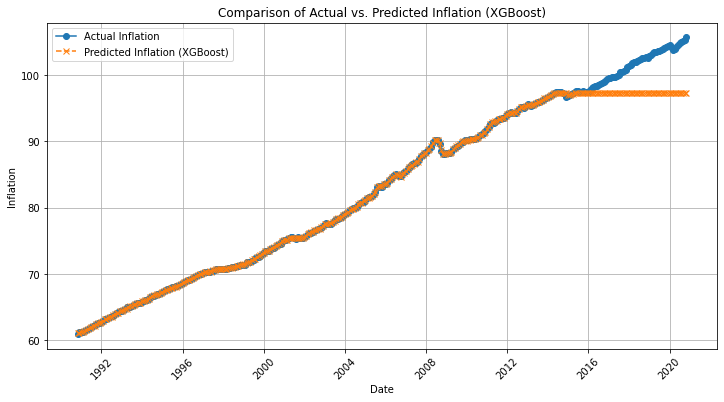

,Date,Actual Inflation,Predicted Inflation,Error
0,1990-11-01,60.945,61.093266,0.148266
1,1990-12-01,61.177,61.093266,0.083734
2,1991-01-01,61.208,61.209538,0.001538
3,1991-02-01,61.221,61.235191,0.014191
4,1991-03-01,61.332,61.337055,0.005055
...,...,...,...,...
95,1998-10-01,71.226,71.236664,0.010664
96,1998-11-01,71.298,71.293716,0.004284
97,1998-12-01,71.398,71.366539,0.031461
98,1999-01-01,71.358,71.494949,0.136949


,Date,Actual Inflation,Predicted Inflation,Error
261,2012-08-01,94.893,94.857635,0.035365
262,2012-09-01,95.174,95.114342,0.059658
263,2012-10-01,95.109,95.176888,0.067888
264,2012-11-01,95.094,95.108971,0.014971
265,2012-12-01,95.275,95.260490,0.014510
...,...,...,...,...
356,2020-07-01,104.887,97.341766,7.545234
357,2020-08-01,105.046,97.341766,7.704234
358,2020-09-01,105.106,97.341766,7.764234
359,2020-10-01,105.225,97.341766,7.883234


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the dataset is sorted by date for proper visualization
df.sort_index(inplace=True)

# Extract relevant columns for visualization
dates = df.index[-len(df):]  # Use only the test set dates
actual_inflation = df["Target"].iloc[-len(dates):]
predicted_inflation = best_xgb_model.predict(df[features].iloc[-len(dates):])

# **Plot Actual vs Predicted Inflation**
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_inflation, label="Actual Inflation", marker="o", linestyle="-")
plt.plot(dates, predicted_inflation, label="Predicted Inflation (XGBoost)", marker="x", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.title("Comparison of Actual vs. Predicted Inflation (XGBoost)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


# Prepare DataFrame for comparison
df_comparison = pd.DataFrame({
    "Date": dates,
    "Actual Inflation": actual_inflation,
    "Predicted Inflation": predicted_inflation,
    "Error": abs(actual_inflation - predicted_inflation)
}).reset_index(drop=True)

from IPython.display import display
display(df_comparison.head(100))  # Show first 100 rows

display(df_comparison.tail(100))


